In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qctrlvisualizer import get_qctrl_style, plot_controls

from qctrl import Qctrl

plt.style.use(get_qctrl_style())

# Start a session with the API.
qctrl = Qctrl()


Q-CTRL package upgrade available. Your version is 9.4.0. New Version is 9.5.0.


## Cloud qubit

In [2]:
control_count = 5
segment_count = 16
duration = 30.0
shot_count = 32

In [95]:
# try sending a zero pulse to get the measurements
meas_count = 8192

zero_control = [{"duration": duration, "values":np.zeros(segment_count)}]
experiment_results = qctrl.functions.calculate_qchack_measurements(
controls = zero_control,
shot_count = meas_count,
) 

Your task calculate_qchack_measurements has completed in 3s.


In [96]:
measurements = experiment_results.measurements

In [97]:
for k, measurement_counts in enumerate(measurements):
    p0 = measurement_counts.count(0) / meas_count
    p1 = measurement_counts.count(1) / meas_count
    p2 = measurement_counts.count(2) / meas_count
    print(f"control #{k}: P(|0>) = {p0:.3f}, P(|1>) = {p1:.3f}, P(|2>) = {p2:.3f}")


control #0: P(|0>) = 0.989, P(|1>) = 0.011, P(|2>) = 0.000


We conclude and assume that the qubit is at state |0> initially because 99.1% is at this state |0> and 0.9% is at state |1>. The small population at state |1> could be due to measurement error.

## Trying Closed-loop optimization

In [102]:
def run_experiments(omegas, exp_0, exp_1, exp_2):
    """
    Simulates a series of experiments where controls `omegas` attempt to apply
    an X gate to a system. The result of each experiment is the infidelity.

    In your actual implementation, this function would run the experiment with
    the parameters passed. Note that the simulation handles multiple test points,
    while your experimental implementation might need to queue the test point
    requests to obtain one at a time from the apparatus.
    """
    controls = []
    control_count = np.shape(omegas)[0]
    
    for k in range(control_count):
        controls.append({"duration": duration, "values": omegas[k]})
        
    experiment_results = qctrl.functions.calculate_qchack_measurements(
controls = controls,
shot_count = shot_count,
) 
    
    measurements = experiment_results.measurements
    
    infidelities = []
    for k, measurement_counts in enumerate(measurements):
        p0 = measurement_counts.count(0) / shot_count
        p1 = measurement_counts.count(1) / shot_count
        p2 = measurement_counts.count(2) / shot_count
        
        # Add error to the measurement.
        infidelities.append(abs(p0 - exp_0) + abs(p1 - exp_1) + abs(p2 - exp_2)) 

    # Return only infidelities between 0 and 1.
    return np.array(infidelities)

In [108]:
# Define the number of test points obtained per run.
test_point_count = 20

# Define parameters as a set of controls with piecewise constant segments.
parameter_set = (
    np.pi
    / duration
    * (np.linspace(-1, 1, test_point_count)[:, None])
    * np.ones((test_point_count, segment_count))
)

# Obtain a set of initial experimental results.
experiment_results = run_experiments(parameter_set, 0. ,1., 0.)

Your task calculate_qchack_measurements has completed in 3s.


In [110]:
# Define initialization object for the automated closed-loop optimization.
length_scale_bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound=1e-5,
    upper_bound=1e5,
)
bound = qctrl.types.closed_loop_optimization_step.BoxConstraint(
    lower_bound=-5 * np.pi / duration,
    upper_bound=5 * np.pi / duration,
)
initializer = qctrl.types.closed_loop_optimization_step.GaussianProcessInitializer(
    length_scale_bounds=[length_scale_bound] * segment_count,
    bounds=[bound] * segment_count,
    rng_seed=0,
)

# Define state object for the closed-loop optimization.
optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
    gaussian_process_initializer=initializer,
)


In [112]:
best_cost, best_controls = min(
    zip(experiment_results, parameter_set), key=lambda params: params[0]
)
optimization_count = 0

sigma = 0.01

# Run the optimization loop until the cost (infidelity) is sufficiently small.
while best_cost > 3 * sigma:
    # Print the current best cost.
    optimization_steps = (
        "optimization step" if optimization_count == 1 else "optimization steps"
    )
    print(
        f"Best infidelity after {optimization_count} BOULDER OPAL {optimization_steps}: {best_cost}"
    )

    # Organize the experiment results into the proper input format.
    results = [
        qctrl.types.closed_loop_optimization_step.CostFunctionResult(
            parameters=list(parameters),
            cost=cost,
            cost_uncertainty=sigma,
        )
        for parameters, cost in zip(parameter_set, experiment_results)
    ]

    # Call the automated closed-loop optimizer and obtain the next set of test points.
    optimization_result = qctrl.functions.calculate_closed_loop_optimization_step(
        optimizer=optimizer,
        results=results,
        test_point_count=test_point_count,
    )
    optimization_count += 1

    # Organize the data returned by the automated closed-loop optimizer.
    parameter_set = np.array(
        [test_point.parameters for test_point in optimization_result.test_points]
    )
    optimizer = qctrl.types.closed_loop_optimization_step.Optimizer(
        state=optimization_result.state
    )

    # Obtain experiment results that the automated closed-loop optimizer requested.
    experiment_results = run_experiments(parameter_set, 0., 1., 0.)

    # Record the best results after this round of experiments.
    cost, controls = min(
        zip(experiment_results, parameter_set), key=lambda params: params[0]
    )
    if cost < best_cost:
        best_cost = cost
        best_controls = controls

# Print final best cost.
print(f"Infidelity: {best_cost}")

# Plot controls that correspond to the best cost.
plot_controls(
    figure=plt.figure(),
    controls={
        r"$\Omega(t)$": [
            {"duration": duration / len(best_controls), "value": value}
            for value in best_controls
        ]
    },
)


Best infidelity after 0 BOULDER OPAL optimization steps: 1.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 5s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 1 BOULDER OPAL optimization step: 1.25


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 5s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 2 BOULDER OPAL optimization steps: 1.1875


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 5s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 3 BOULDER OPAL optimization steps: 0.9375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 5s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 4 BOULDER OPAL optimization steps: 0.9375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 5s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 5 BOULDER OPAL optimization steps: 0.9375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 5s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 6 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 5s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 7 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 11s.


Your task calculate_qchack_measurements is currently in a queue waiting to be processed.
Your task calculate_qchack_measurements has completed in 7s.
Best infidelity after 8 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 9s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 9 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 9s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 10 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 11s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 11 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 13s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 12 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 15s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 13 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 27s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 14 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 17s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 5s.
Best infidelity after 15 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 19s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 16 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 21s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 17 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 42s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 18 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 29s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 19 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 32s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 20 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 30s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 7s.
Best infidelity after 21 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 36s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 22 BOULDER OPAL optimization steps: 0.5


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 71s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 5s.
Best infidelity after 23 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 34s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 24 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 87s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 25 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 58s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 26 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 50s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 27 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 67s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 28 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 73s.


Your task calculate_qchack_measurements has started.
Your task calculate_qchack_measurements has completed in 7s.
Best infidelity after 29 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 82s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 30 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 75s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 31 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 110s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 32 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 108s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 33 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 108s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 34 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 135s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 35 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 130s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 36 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step is currently in a queue waiting to be processed.
Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 236s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 37 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step is currently in a queue waiting to be processed.
Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 125s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 38 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 155s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 39 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 145s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 40 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.
Your task calculate_closed_loop_optimization_step has completed in 145s.


Your task calculate_qchack_measurements has completed in 3s.
Best infidelity after 41 BOULDER OPAL optimization steps: 0.4375


Your task calculate_closed_loop_optimization_step has started.


KeyboardInterrupt: 

Infidelity: 0.4375


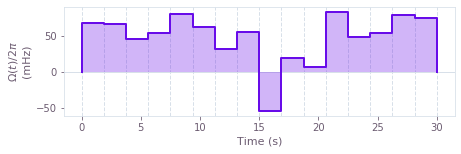

In [113]:
# Print final best cost.
print(f"Infidelity: {best_cost}")

# Plot controls that correspond to the best cost.
plot_controls(
    figure=plt.figure(),
    controls={
        r"$\Omega(t)$": [
            {"duration": duration / len(best_controls), "value": value}
            for value in best_controls
        ]
    },
)